In [1]:
import pandas as pd
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gaurav.gupta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:

def read_file():
    df = pd.read_csv('/home/gaurav.gupta/projects/PoCs/brandMention/brand_datasets/ds_complaints/panasonic_v1_g.csv')
    df = df[['text', 'Complaint']]
    return df
# df.head(2)

In [37]:
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
import re
import ftfy
import scrubadub
# import string
from tabulate import tabulate
import demoji
# import emoji
from nltk.corpus import stopwords


stop = stopwords.words('english')
emailDetector = scrubadub.Scrubber(detector_list=[scrubadub.detectors.EmailDetector])
wnl = WordNetLemmatizer()

label_codes = {'No': 0, 'Yes': 1}
t_handle_regex = r'(^|[^@\w])@(\w{1,15})\b'
t_hashtag_regex = r"#(\w+)"
t_handle_placeholder = ' {{HANDLE}}'
t_hashtag_placeholder = ' {{HASHTAG}}'
emoji_placeholder = '{{EMOJI}}'
# domain specific stopwords.
stop.extend(['panasonic'])

# table = str.maketrans("", "")


def penn_to_wn(tag):
    def is_noun(tag):
        return tag in ['NN', 'NNS', 'NNP', 'NNPS']

    def is_verb(tag):
        return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

    def is_adverb(tag):
        return tag in ['RB', 'RBR', 'RBS']

    def is_adjective(tag):
        return tag in ['JJ', 'JJR', 'JJS']

    # Pos tags to wn tags
    if is_adjective(tag):
        return wn.ADJ
    elif is_noun(tag):
        return wn.NOUN
    elif is_adverb(tag):
        return wn.ADV
    elif is_verb(tag):
        return wn.VERB
    return None

def to_lower_case(text):
    return text.lower()

def fix_unicode(text):
    return ftfy.fix_text(text)

def replace_email(text):
    return emailDetector.clean(text)

def remove_stop_words(text):
    return ' '.join([word for word in text.split() if word not in (stop)])

def convert_emoji_to_text(text):
    return text

def replace_user_name(text):
    return re.sub(t_handle_regex, t_handle_placeholder, text)

def replace_hashtags(text):
    return re.sub(t_hashtag_regex, t_hashtag_placeholder,text)

def remove_punctuations(text):
    return re.sub(r'[^\w\s]', '', text)

def replace_emoji_with_code(text):
    demoji.replace(text, repl=emoji_placeholder)
    return demoji.replace_with_desc(text)

def get_stats(step, df):
    corpus = " ".join(list(df['text']))
    total_words = len(corpus.split(' '))
    unique_words = len(set(corpus.split(' ')))
    return [step, total_words, unique_words]

def lemmatize(text):
    default_wn_tag = 'n'
    tokens = text.split(' ')
    pos_tags = nltk.pos_tag(tokens)
    wn_tags = [penn_to_wn(tag) for (w, tag) in pos_tags]
    # print(list(zip(pos_tags, wn_tags)))
    lemmas = [wnl.lemmatize(token, tag or default_wn_tag) for (token, tag) in list(zip(tokens, wn_tags))]
    return ' '.join(lemmas)

stats = [['Step', 'Total words', 'Unique words']]
df = read_file()
stats.append(get_stats('Start', df))
df = df.replace(label_codes)

df['text'] = df['text'].apply(lambda text: text.lower())
stats.append(get_stats('Lower', df))

df['text'] = df['text'].apply(lambda text: lemmatize(text))
stats.append(get_stats('Lemmatize', df))

df['text'] = df['text'].apply(fix_unicode)
stats.append(get_stats('Unicode Fix', df))

df['text'] = df['text'].apply(replace_emoji_with_code)
stats.append(get_stats('Replace emoji', df))

df['text'] = df['text'].apply(remove_stop_words)
stats.append(get_stats('Stop words', df))

df['text'] = df['text'].apply(replace_email)
stats.append(get_stats('Email Replace', df))

df['text'] = df['text'].apply(replace_user_name)
stats.append(get_stats('UserName replace', df))

df['text'] = df['text'].apply(replace_hashtags)
stats.append(get_stats('HashTags Replace', df))

df['text'] = df['text'].apply(remove_punctuations)
stats.append(get_stats('Remove punctuation', df))


print(tabulate(stats))


------------------  -----------  ------------
Step                Total words  Unique words
Start               50105        13092
Lower               50105        11752
Lemmatize           50105        11159
Unicode Fix         50094        11124
Replace emoji       50279        11157
Stop words          36490        10611
Email Replace       36490        10609
UserName replace    37125        9762
HashTags Replace    46119        7497
Remove punctuation  46119        6278
------------------  -----------  ------------


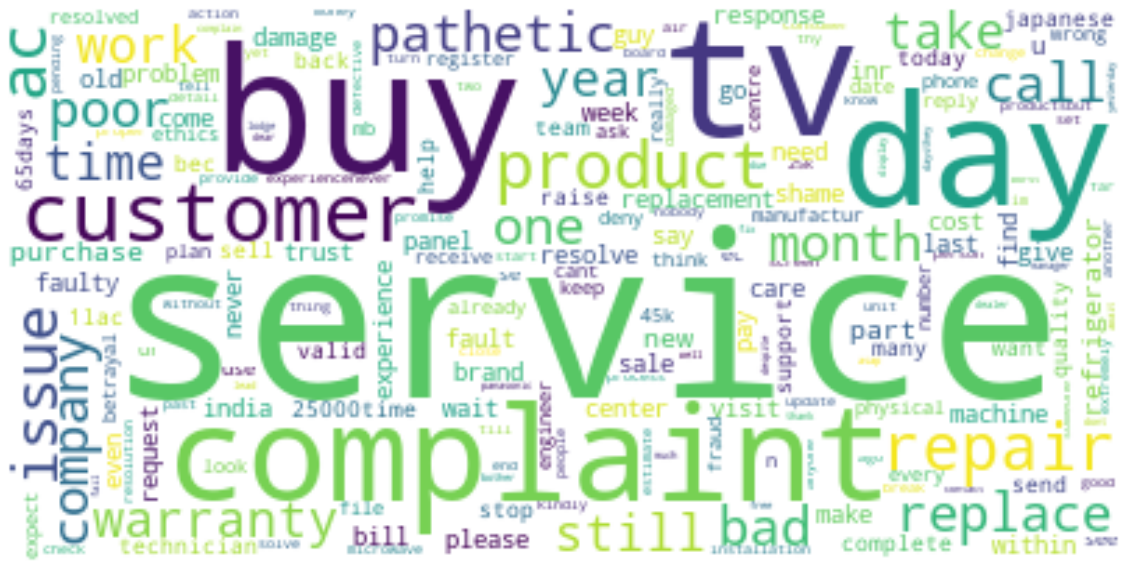

In [73]:
#Importing Libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 16))
# corpus = " ".join(list(df['text']))
corpus = " ".join(list(df[df['Complaint'] == 1]['text']))

word_cloud = WordCloud(collocations=False, background_color='white').generate(
    corpus.replace('HASHTAG', '').replace('HANDLE', ''))

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [70]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(lowercase=False, max_df=.8, min_df=0.01)
tfidf_wm = tfidf.fit_transform(df[''])
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['Complaint'])

pd.DataFrame(data=tfidf_wm.toarray(), columns=tfidf.get_feature_names()).T




,0,1,2,3,4,5,6,7,8,9,...,1224,1225,1226,1227,1228,1229,1230,1231,1232,1233
10,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0
24,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0
6999,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0
91,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0
HANDLE,0.603743,0.417855,0.0,0.756656,0.0,0.0,0.935585,0.0,0.327891,0.0,...,0.0,0.370437,0.718841,0.0,0.09479,0.0,0.0,0.091342,0.157671,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
worth,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0
would,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0
wrong,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0
year,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0
